# Trophic model for gut
## Consumer-Resource model (CRM) with Trophic levels
The human gut microal community is complex because of 3 reason: (1) many microbial species (~570); (2) many metabolites involoved (~244); and (3) many microbe-metabolite interactions/links (>4400). Of all types of microbe-metabolite interactions/links, the cross-feeding makes the system more complicated to interpret. Previously, a literature-curated interspecies network of the human gut microbiota, called [NJS16](https://www.nature.com/articles/ncomms15393) is reported. This is an extensive data resource composed of ∼570 microbial species and 3 human cell types metabolically interacting through >4,400 small-molecule transport and macromolecule degradation events.

Here, we devoted to build a Consumer-Resource model (CRM) with trophic levels posted in the paper "[a evidence for a multi-level trophic organization of the human gut microbiome](https://www.biorxiv.org/content/10.1101/603365v1.full-text)". The model is devoted to study the complex microbe-metabolite network in human guts.

In concise, in the mode, a trophic level is considered as one round of carbon processing and is composed of two process: resource allocation to microbes and the following resource/byproduct generation by microbes. The simulation is stopped after several trophic levels because the residence time of resource in the human gut is assumed to be finite.

Previously, the code for the model is written in Matlab. Here a Python version of the model is proposed, providing further convenience for Machine Learning model to learn uptake rates and byproduct generation rates of all microbial species to different metabolites.

In [1]:
import pandas as pd
import numpy as np
import math
import random
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from scipy.stats import sem

#%% Plot Tong's default setting
SMALL_SIZE = 12
MEDIUM_SIZE = 15
BIGGER_SIZE = 15

plt.rc('font', size=SMALL_SIZE, family='sans-serif', serif='Arial')          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc('text')

from matplotlib.ticker import MaxNLocator
my_locator = MaxNLocator(6)

color_list = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

def figure_size_setting(WIDTH):
    #WIDTH = 700.0  # the number latex spits out
    FACTOR = 0.8  # the fraction of the width you'd like the figure to occupy
    fig_width_pt  = WIDTH * FACTOR
    inches_per_pt = 1.0 / 72.27
    golden_ratio  = (np.sqrt(5) - 1.0) / 2.0  # because it looks good
    fig_width_in  = fig_width_pt * inches_per_pt  # figure width in inches
    fig_height_in = fig_width_in * golden_ratio   # figure height in inches
    fig_dims    = [fig_width_in, fig_height_in] # fig dims as a list
    return fig_dims

In [2]:
########### import the pickled file containing all processed data which are useful for simulations (the processing is
########### done in "Trophic_model_for_gut_data_processing.ipynb")
import pickle
pickle_in = open("Chia_network.pickle","rb")
net, i_selfish, i_intake, names = pickle.load(pickle_in)

pickle_in = open("data.pickle","rb")
metagenome_ID, metagenome, metabolome_ID, metabolome = pickle.load(pickle_in)


## Create maps of microbes and metabolites to their reduced matrix forms

In [3]:
#i_nonzero_microbes = net['microbes_ID'].unique()
#i_nonzero_microbes = np.sort(i_nonzero_microbes)
i_nonzero_microbes = metagenome_ID.values.copy()
i_nonzero_metabolites = net['metabolites_ID'].unique()
i_nonzero_metabolites = np.sort(i_nonzero_metabolites)


df_metabolites = pd.DataFrame.from_dict({'oldID': i_nonzero_metabolites, 'newID':list(range(len(i_nonzero_metabolites)))})
df_metabolites.set_index('oldID', inplace=True)
df_microbes = pd.DataFrame.from_dict({'oldID': i_nonzero_microbes, 'newID':list(range(len(i_nonzero_microbes)))})
df_microbes.set_index('oldID', inplace=True)


outgoingNodes = df_metabolites.loc[net['metabolites_ID'].values].values.flatten()
ingoingNodesTemp = df_microbes.loc[net['microbes_ID'].values].values.flatten()
edge_types = net.iloc[~np.isnan(ingoingNodesTemp),2].values
outgoingNodes = outgoingNodes[~np.isnan(ingoingNodesTemp)]
ingoingNodes = ingoingNodesTemp[~np.isnan(ingoingNodesTemp)].astype(int)

net_reduced = pd.DataFrame.from_dict({'metabolites': outgoingNodes, 'microbes':ingoingNodes, 'edgeType':edge_types})
net = net_reduced.copy()
net_temp = net.copy()
net['edgeType'][net['edgeType']==5] = 2
net_temp['edgeType'][net_temp['edgeType']==5] = 3
net = net.append(net_temp).drop_duplicates()
net_ori = net.copy()

metagenome_ID_reduced = df_microbes.loc[metagenome_ID].values.flatten()
metagenome_ID = metagenome_ID_reduced[~np.isnan(metagenome_ID_reduced)].astype(int)

metabolome_ID_reduced = df_metabolites.loc[metabolome_ID].values.flatten()
metabolome_ID = metabolome_ID_reduced[~np.isnan(metabolome_ID_reduced)].astype(int)


i_selfish_reduced = df_microbes.loc[i_selfish].values.flatten()
i_selfish = i_selfish_reduced[~np.isnan(i_selfish_reduced)].astype(int)

i_intake_reduced = df_metabolites.loc[i_intake].values.flatten()
i_intake = i_intake_reduced[~np.isnan(i_intake_reduced)].astype(int)


/Users/tongwang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  from ipykernel import kernelapp as app
/Users/tongwang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike


In [4]:
len(net_ori)

1075

## Run the simulation with reduced matrix forms for one individual

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 3.150813280364595
            Iterations: 16
            Function evaluations: 354
            Gradient evaluations: 16
     fun: 3.150813280364595
     jac: array([ 0.        ,  0.00985742,  0.00507501,  0.00553936,  0.06272534,
        0.01278245,  0.03304654,  0.00766429, -0.00600919,  0.01459843,
        0.00206965,  0.01478863,  0.12712216,  0.08330959, -0.00155345,
        0.01078972,  0.08886304,  0.02255568, -0.01123685,  0.01378873])
 message: 'Optimization terminated successfully.'
    nfev: 354
     nit: 16
    njev: 16
  status: 0
 success: True
       x: array([5.00000000e-02, 1.10194613e-01, 4.62982166e+00, 3.86162425e-01,
       0.00000000e+00, 1.47368555e-16, 0.00000000e+00, 7.21666785e-02,
       3.79356843e-02, 5.02151329e-17, 4.71539162e-01, 1.65348559e-02,
       0.00000000e+00, 4.01310415e-16, 3.52982093e-01, 2.22130587e-01,
       0.00000000e+00, 0.00000000e+00, 2.19499696e-

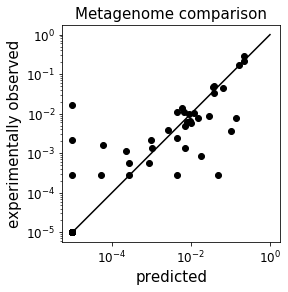

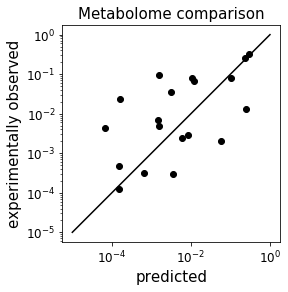

In [5]:
################################# Predict metabolome from individual's metagenome.
from numpy import array
from scipy.sparse import csr_matrix
import numpy.matlib
from scipy.optimize import minimize, rosen, rosen_der
from scipy.stats import pearsonr

MAX_ID_microbes = len(i_nonzero_microbes)  # MAX_ID_microbes is the maximum of ID labels for microbes.
MAX_ID_metabolites = len(i_nonzero_metabolites)  # MAX_ID_metabolites is the maximum of ID labels for metabolites.

def Ain_out(b_real, net):
    '''
    Ain_out is a function used to create sparse matrices made of metabolites and microbes 
    where metabolite consumption and production is considered. The matrices created are "m2b" and "b2m":
    (1) m2b is a matrix determines the nutrient splitting among microbes, and
    (2) b2m is a matrix determines the byproducts generation.
    Both matrices have rows representing bacterial species and columns representing metablolites.
    Two matrices are created based on (1) the metabolite consumption and production network which is 
    encode in "net" as a dataframe, and (2) the experimentally measured bacterial abundance "b_real".
    '''
    valid_index = np.where((net['edgeType']==2) | (net['edgeType']==5))[0]
    row = net['metabolites'].iloc[valid_index]
    col = net['microbes'].iloc[valid_index]
    data = np.ones((len(valid_index),))
    m2b = csr_matrix( (data,(row,col)), shape=(MAX_ID_metabolites, MAX_ID_microbes)).toarray()#.todense()

    valid_index = np.where((net['edgeType']==3) | (net['edgeType']==5))[0]
    row = net['metabolites'].iloc[valid_index]
    col = net['microbes'].iloc[valid_index]
    data = np.ones((len(valid_index),))
    b2m = csr_matrix( (data,(row,col)), shape=(MAX_ID_metabolites, MAX_ID_microbes)).toarray()#.todense()

    ########## Normalize the b2m by out_degree
    out_degree = b2m.sum(0).copy()
    out_degree[out_degree==0]=100
    b2m = (b2m / out_degree)

    ########## Normalize the m2b by proportion of microbial abundance in each individual
    b_real_repmat = numpy.matlib.repmat(b_real[np.newaxis,:], MAX_ID_metabolites, 1)
    m2b = m2b * b_real_repmat
    in_degree = m2b.sum(1)
    in_degree[in_degree==0]=100
    m2b = m2b / numpy.matlib.repmat(in_degree[:,np.newaxis], 1, MAX_ID_microbes)
    m2b = np.float32(m2b)
    b2m = np.float32(b2m)
    return [m2b, b2m]

def m2b_multiple_levels(f, m2b, b2m, numLevels_max):
    '''
    m2b_multiple_levels is a function used to generate matrices involving the calculation of metabolite 
    byproducts and microbial biomass after several trophic levels/layers. Those matrices are:
    (1) m2m_layer is a conversion matrix from the nutrient intake to the metabolite byproducts at a trophic
    level or layer.
    (2) m2m_total is a conversion matrix from the nutrient intake to a summation of metabolite byproducts at
    all trophic levels or layers.
    (3) m2b_total is a conversion matrix from the nutrient intake to a summation of all microbial/bacterial 
    biomass gain at all trophic levels or layers.
    Those matrices are computed based on (1) metabolite consumption matrix "m2b", (2) metabolite byproduct
    generation matrix "b2m", (3) byproduct/leakage fraction "f", and (4) number of trophic levels/layers in the 
    simulation "numLevels_max".
    '''
    m2m_layer = np.zeros((MAX_ID_metabolites, MAX_ID_metabolites, numLevels_max));  
    #m2b_total = np.zeros((MAX_ID_metabolites, MAX_ID_microbes));  
    m2b_total = np.zeros((MAX_ID_metabolites, MAX_ID_metabolites));  
    
    f_mul = numpy.matlib.repmat(f, 1, MAX_ID_metabolites)
    #s_step =  np.dot(b2m, m2b.T) # s_step is the conversion matrix of each trophic level/layer
    s_step =  np.dot(b2m, f_mul*m2b.T) # s_step is the conversion matrix of each trophic level/layer
    s_step_ii = np.eye(MAX_ID_metabolites, MAX_ID_metabolites);
    #f_mul = numpy.matlib.repmat(f[np.newaxis,:], MAX_ID, 1)#numpy.matlib.repmat(f, 1, MAX_ID)
    #f_mul = numpy.matlib.repmat(f, 1, MAX_ID_metabolites)
    
    for ii in range(numLevels_max):
        # m2b_total is a series made of s_step of each layer
        #m2b_total = m2b_total + f_mul**(ii) * s_step_ii
        #m2m_layer[:,:,ii] = f_mul**(ii) * s_step_ii
        m2b_total = m2b_total + s_step_ii
        m2m_layer[:,:,ii] = s_step_ii
        s_step_ii = np.dot(s_step_ii, s_step);  
    m2m_total = m2b_total;
    m2b_total = np.dot((1 - f_mul) * m2b.T, m2b_total) # m2b_total has an extra multiplication of m2b and (1-f).
    return [m2b_total, m2m_total, m2m_layer]

def pred_error(x, b_real, m2b_total, i_intake):
    '''
    pred_error is a function used to compute the logarithmic error between experimentally measured
    metagenome and predicted metagenome computed from the model for a certain nutrient intake. It relies on 
    (1) x: the nutrient intake, (2) i_intake: IDs of the nutrient intake, (3) m2b_total: a conversion matrix 
    from thenutrient intake to the total biomass, and (4) b_real: experimentally measured metagenome. The 
    first three is used to compute the metagenome predicted by the model "ba_pred" and compare it with the 
    experimentally measured metagenome "b_real".
    '''
    x_full = np.zeros((MAX_ID_metabolites,));
    x_full[i_intake] = x;
    
    ba_pred = np.dot(m2b_total, x_full)
    pred_error = (np.log10(ba_pred + 1e-6) - np.log10(b_real +1e-6)) / np.log10(b_real +1e-6);
    pred_error = np.sqrt(np.dot(pred_error, pred_error.T)) #np.sqrt(np.sum(pred_error**2))
    return pred_error

def calc_metabolome(x, m2m_layer, numLevels_max, i_intake):
    '''
    calc_metabolome is a function used to calculate the metabolome from the fitted nutrient intake from the
    model. It relies on (1) x: the nutrient intake, (2) i_intake: IDs of the nutrient intake, (3) m2m_layer: 
    a conversion matrix from the nutrient intake to the metabolite byproducts at a trophic level or layer, 
    and (4) numLevels_max: the number of trophic levels/layers in the model. The metabolome in the model is 
    assumed to be composed of two parts: (1) met_levels: all metabolites in the final trophic level/layer 
    (which is considered to be reaching the end of the gut because of the finite gut length and gut motility.),
    and (2) met_leftover_levels: all unusable metabolites from all previous trophic levels/layers. 
    '''
    i_unused = np.where(np.sum(m2b.T,0) == 0)[0]
    met_levels = np.zeros((MAX_ID_metabolites, numLevels_max));  
    met_leftover_levels = np.zeros((MAX_ID_metabolites, numLevels_max));
    
    x_full = np.zeros((MAX_ID_metabolites,));
    x_full[i_intake] = x;
    
    for ii in range(numLevels_max):
        met_levels[:,ii] = np.dot(m2m_layer[:,:,ii], x_full)
        if ii==0:
            met_leftover_levels[i_unused,ii] = x_full[i_unused]
        else:
            met_leftover_levels[i_unused,ii] = met_levels[i_unused,ii-1]
            
    return [met_levels, met_leftover_levels]

f_byproduct = 0.9
f = f_byproduct * np.ones((MAX_ID_microbes,1));
f[i_selfish] = 0.0;  # The byproduct/leakage fraction f for microbes that don't generate byproducts is set as 0.

numLevels_max = 4

######## Select an ID of a individual and pull out its experimentally measured metagenome:
pa = 5; 
b_real = np.zeros((MAX_ID_microbes,))
b_real[metagenome_ID] = metagenome.iloc[:,pa] / np.sum(metagenome.iloc[:,pa])

######## Compute matrices involving the metabolite consumption and generation:
m2b, b2m = Ain_out(b_real, net)
m2b_total, m2m_total, m2m_layer = m2b_multiple_levels(f, m2b, b2m, numLevels_max)
#m2b_total, m2m_total, m2m_layer = m2b_multiple_levels(i_nonzero_microbes, i_nonzero_metabolites, f, m2b, b2m, numLevels_max)

######## Assign diet
x0 = np.ones((len(i_intake),)) / len(i_intake)

######## The model is converted into an optimization problem where the nutrient intake is constantly changed to
# minimize the logarithmic error between experimentally measured metagenome and predicted metagenome computed 
# from the model for a certain nutrient intake.
fun = lambda x: pred_error(x, b_real, m2b_total, i_intake)
bnds = ((0, 100), ) * len(x0)
res = minimize(fun, x0, method='SLSQP', bounds=bnds, options={'disp': True, 'maxiter': 1000}, tol=1e-3)
#res = minimize(fun, x0, method='Nelder-Mead', bounds=bnds, options={'disp': True})
#res = minimize(fun, x0, method='TNC', bounds=bnds, options={'disp': True, 'maxiter': 1000})
print(res)

######## As long as the optimized nutrient intake is found by using the above optimization solver, the
# optimized nutrient intake "res.x" is used to generate the predict metagenome and metabolome. They are
# visually and statistically compared to the experimentally measured metagenome and metabolome.
x_full = np.zeros((MAX_ID_metabolites,));
x_full[i_intake] = res.x;
ba_pred = np.dot(m2b_total, x_full)

#### Metagenome comparison
fig, ax = plt.subplots()
ax.loglog(ba_pred+1e-5, b_real+1e-5, 'ko')
ax.plot([1e-5, 1], [1e-5, 1],'k-')
ax.set_aspect('equal')
ax.set_xlabel('predicted')
ax.set_ylabel('experimentally observed')
ax.set_title('Metagenome comparison')

met_levels, met_leftover_levels = calc_metabolome(res.x, m2m_layer, numLevels_max, i_intake)
metabolome_measured = np.zeros((MAX_ID_metabolites,))
#metabolome_measured[metabolome_ID.values] = metabolome.iloc[:,pa]
metabolome_measured[metabolome_ID] = metabolome.iloc[:,pa]
metabolome_pred = met_levels[:, -1] + met_leftover_levels.sum(1) #np.dot(m2m_total, x_full)
#metabolome_pred = np.dot(m2m_total, x_full)
i_common = np.where(metabolome_measured * metabolome_pred > 1e-5)[0]
metabolome_pred_common = metabolome_pred[i_common] / np.sum(metabolome_pred[i_common])
metabolome_measured_common = metabolome_measured[i_common] / np.sum(metabolome_measured[i_common])

#### Metabolome comparison
fig, ax = plt.subplots()
ax.loglog(metabolome_pred_common+1e-5, metabolome_measured_common+1e-5, 'ko')
ax.plot([1e-5, 1], [1e-5, 1],'k-')
ax.set_aspect('equal')
ax.set_xlabel('predicted')
ax.set_ylabel('experimentally observed')
ax.set_title('Metabolome comparison')

print('-------------------------------------------------------------------------------------------------------------')
print('(Correlation coefficient, P-value) of the correlation between predicted and experimentally measured metagonome:')
print(pearsonr(ba_pred[b_real>0], b_real[b_real>0]))
print('(Correlation coefficient, P-value) of the correlation between predicted and experimentally measured metabolome:')
print(pearsonr(metabolome_pred_common, metabolome_measured_common))


## Run the simulation with reduced matrix forms for all individuals

In [5]:
corr_list = np.zeros((metabolome.shape[1],2))
diet_list = np.zeros((metabolome.shape[1], 20))
for pa in range(metabolome.shape[1]):
    print(pa)
    ######## Select an ID of a individual and pull out its experimentally measured metagenome:
    b_real = np.zeros((MAX_ID_microbes,))
    b_real[metagenome_ID] = metagenome.iloc[:,pa] / np.sum(metagenome.iloc[:,pa])

    ######## Compute matrices involving the metabolite consumption and generation:
    m2b, b2m = Ain_out(b_real, net)
    #m2b_total, m2m_total, m2m_layer = m2b_multiple_levels(f, m2b, b2m, numLevels_max)
    m2b_total, m2m_total, m2m_layer = m2b_multiple_levels(f, m2b, b2m, numLevels_max)

    ######## Assign diet
    x0 = np.ones((len(i_intake),)) / len(i_intake)

    ######## The model is converted into an optimization problem where the nutrient intake is constantly changed to
    # minimize the logarithmic error between experimentally measured metagenome and predicted metagenome computed 
    # from the model for a certain nutrient intake.
    fun = lambda x: pred_error(x, b_real, m2b_total, i_intake)
    bnds = ((0, 100), ) * len(x0)
    res = minimize(fun, x0, method='SLSQP', bounds=bnds, options={'maxiter': 1000}, tol=1e-3)

    ######## As long as the optimized nutrient intake is found by using the above optimization solver, the
    # optimized nutrient intake "res.x" is used to generate the predict metagenome and metabolome. They are
    # visually and statistically compared to the experimentally measured metagenome and metabolome.
    x_full = np.zeros((MAX_ID_metabolites,));
    x_full[i_intake] = res.x;
    ba_pred = np.dot(m2b_total, x_full)

    met_levels, met_leftover_levels = calc_metabolome(res.x, m2m_layer, numLevels_max, i_intake)
    metabolome_measured = np.zeros((MAX_ID_metabolites,))
    metabolome_measured[metabolome_ID] = metabolome.iloc[:,pa]
    metabolome_pred = met_levels[:, -1] + met_leftover_levels.sum(1) #np.dot(m2m_total, x_full)
    i_common = np.where(metabolome_measured * metabolome_pred > 1e-5)[0]
    metabolome_pred_common = metabolome_pred[i_common] / np.sum(metabolome_pred[i_common])
    metabolome_measured_common = metabolome_measured[i_common] / np.sum(metabolome_measured[i_common])
    if i_common.shape[0] >= 2:
        corr_list[pa, 0] = pearsonr(ba_pred[b_real>0], b_real[b_real>0])[0]
        corr_list[pa, 1] = pearsonr(np.log10(metabolome_pred_common+1e-5), np.log10(metabolome_measured_common+1e-5))[0]
    else:
        corr_list[pa, 0] = -1
        corr_list[pa, 1] = -1
    
    diet_list[pa, :] = res.x

    print('-------------------------------------------------------------------------------------------------------------')
    print('(Correlation coefficient, P-value) of the correlation between predicted and experimentally measured metagonome:')
    print(corr_list[pa, 0])
    print('(Correlation coefficient, P-value) of the correlation between predicted and experimentally measured metabolome:')
    print(corr_list[pa, 1])

0
-------------------------------------------------------------------------------------------------------------
(Correlation coefficient, P-value) of the correlation between predicted and experimentally measured metagonome:
0.4264852667826321
(Correlation coefficient, P-value) of the correlation between predicted and experimentally measured metabolome:
0.6529538363213333
1
-------------------------------------------------------------------------------------------------------------
(Correlation coefficient, P-value) of the correlation between predicted and experimentally measured metagonome:
0.9011443329682665
(Correlation coefficient, P-value) of the correlation between predicted and experimentally measured metabolome:
0.5125408038131118
2
-------------------------------------------------------------------------------------------------------------
(Correlation coefficient, P-value) of the correlation between predicted and experimentally measured metagonome:
0.8058052669743445
(Correlat

-------------------------------------------------------------------------------------------------------------
(Correlation coefficient, P-value) of the correlation between predicted and experimentally measured metagonome:
0.8927271146910619
(Correlation coefficient, P-value) of the correlation between predicted and experimentally measured metabolome:
0.7756813440676168
24
-------------------------------------------------------------------------------------------------------------
(Correlation coefficient, P-value) of the correlation between predicted and experimentally measured metagonome:
0.9693578076516381
(Correlation coefficient, P-value) of the correlation between predicted and experimentally measured metabolome:
0.535209432735657
25
-------------------------------------------------------------------------------------------------------------
(Correlation coefficient, P-value) of the correlation between predicted and experimentally measured metagonome:
0.4050883391885774
(Correlati

In [6]:
print("The mean Pearson correlation coefficient is", np.mean(corr_list[:,1]))


The mean Pearson correlation coefficient is 0.6108124558596347


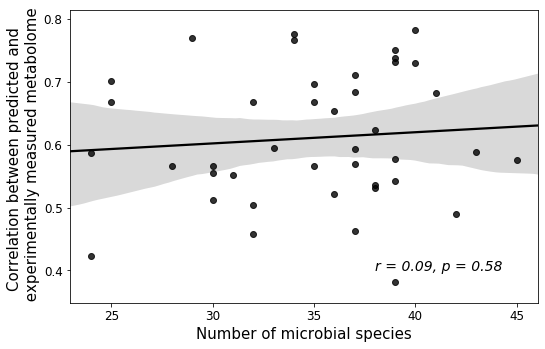

In [7]:
num_of_species = np.sum(metagenome>0, 0)
corr_metabolome = corr_list[:,1]
df_individual_performance = pd.DataFrame({"num_of_species":num_of_species, "corr_metabolome":corr_metabolome})

fig_dims = figure_size_setting(700)
fig, axes = plt.subplots(1, 1, figsize=fig_dims, sharex=True)
g = sns.regplot(x="num_of_species", y="corr_metabolome", color='black', data=df_individual_performance, ax=axes);
#g.set_ax_joint.text(145, 95, 'r = 0.45, p < .001', fontstyle='italic')
[r, p] = pearsonr(num_of_species, corr_metabolome)
axes.text(38, 0.4, 'r = '+str(np.round(r,2))+', p = '+str(np.round(p,2)), fontstyle='italic', fontsize=14)
#g.set_ax_joint.text
#axes.plot(num_of_species, corr_metabolome,'ko')
axes.set_xlabel('Number of microbial species')
axes.set_ylabel('Correlation between predicted and \n experimentally measured metabolome')
fig.subplots_adjust(left=.13, bottom=.12, right=.97, top=.97, hspace=0.2)
fig.savefig("./no_correlation_between_#species_performance.pdf", dpi=600)

## Monte Carlo over adding links (using the optimized diet)

## No training-test splitting

In [10]:
import random
######## Select all microbes in the Thai data:
b_real = np.zeros((MAX_ID_microbes,))
b_real[metagenome_ID] = 0.05

######## Compute matrices involving the metabolite consumption and generation:
m2b, b2m = Ain_out(b_real, net)

######## Keep a record of the original network
m2b_ori = (m2b!=0).astype(int).copy()
b2m_ori = (b2m!=0).astype(int).copy()
x_ori = np.concatenate([m2b_ori.flatten(), b2m_ori.flatten()])
net_ori = net.copy()

def pred_error_addingLinks(x, m2b_ori, b2m_ori, x_ori):
    '''
    pred_error_addingLinks is a function used to compute the logarithmic error between experimentally measured
    metagenome and predicted metagenome computed from the model for a certain nutrient intake. It relies on 
    (1) x: the nutrient intake, (2) i_intake: IDs of the nutrient intake, (3) m2b_total: a conversion matrix 
    from thenutrient intake to the total biomass, and (4) b_real: experimentally measured metagenome. The 
    first three is used to compute the metagenome predicted by the model "ba_pred" and compare it with the 
    experimentally measured metagenome "b_real".
    '''
    max_links = m2b_ori.shape[0] * m2b_ori.shape[1] # maximal number of links = numberr of specis * number of metabolites
    
    ######## Convert x to net structure (convert the adjacency matrix into the edge list):
    thres = 0.1
    x = x - x_ori
    ### consumption links:
    m2b_added = x[:max_links].reshape((m2b_ori.shape[0], m2b_ori.shape[1]))
    a = df_metabolites['newID'].values[np.where(m2b_added >= thres)[0]]
    b = metagenome_ID[np.where(m2b_added >= thres)[1]]
    c = [2] * np.where(m2b_added >= thres)[1].shape[0]
    net_added_consumption = pd.DataFrame({net_ori.columns[0]:list(a), net_ori.columns[1]:list(b), net_ori.columns[2]:c})
    ### production links:
    b2m_added = x[max_links:].reshape((m2b_ori.shape[0], m2b_ori.shape[1]))
    a = df_metabolites['newID'].values[np.where(b2m_added >= thres)[0]]
    b = metagenome_ID[np.where(b2m_added >= thres)[1]]
    c = [3] * np.where(b2m_added >= thres)[1].shape[0]
    net_added_production = pd.DataFrame({net_ori.columns[0]:list(a), net_ori.columns[1]:list(b), net_ori.columns[2]:c})
    ### overall edge list of the new network
    net = pd.concat([net_ori, net_added_consumption, net_added_production])
    
    f_byproduct = 0.9
    f = f_byproduct * np.ones((MAX_ID_microbes,1));
    f[i_selfish] = 0.0;  # The byproduct/leakage fraction f for microbes that don't generate byproducts is set as 0.

    numLevels_max = 4

    corr_list_aveDiet = np.zeros((metabolome.shape[1],2))
    log_list_aveDiet = np.zeros((metabolome.shape[1],2))
    order_dev_list = np.zeros((metabolome.shape[1], MAX_ID_metabolites))
    order_dev_metagenome_list = np.zeros((metabolome.shape[1], MAX_ID_microbes))
    numMetabolites_list = np.zeros((metabolome.shape[1]))
    for pa in range(metabolome.shape[1]):
        ######## Select an ID of a individual and pull out its experimentally measured metagenome:
        b_real = np.zeros((MAX_ID_microbes,))
        b_real[metagenome_ID] = metagenome.iloc[:,pa] / np.sum(metagenome.iloc[:,pa])

        ######## Compute matrices involving the metabolite consumption and generation:
        m2b, b2m = Ain_out(b_real, net)
        #m2b_total, m2m_total, m2m_layer = m2b_multiple_levels(f, m2b, b2m, numLevels_max)
        m2b_total, m2m_total, m2m_layer = m2b_multiple_levels(f, m2b, b2m, numLevels_max)

        ######## As long as the optimized nutrient intake is found by using the above optimization solver, the
        # optimized nutrient intake "res.x" is used to generate the predict metagenome and metabolome. They are
        # visually and statistically compared to the experimentally measured metagenome and metabolome.
        
        ######## Assign diet
        x0 = np.ones((len(i_intake),)) / len(i_intake)

        ######## The model is converted into an optimization problem where the nutrient intake is constantly changed to
        # minimize the logarithmic error between experimentally measured metagenome and predicted metagenome computed 
        # from the model for a certain nutrient intake.
        fun2 = lambda y: pred_error(y, b_real, m2b_total, i_intake)
        bnds = ((0, 100), ) * len(x0)
        res = minimize(fun2, x0, method='SLSQP', bounds=bnds, options={'disp': False, 'maxiter': 1000}, tol=1e-3, callback=None)

        ######## As long as the optimized nutrient intake is found by using the above optimization solver, the
        # optimized nutrient intake "res.x" is used to generate the predict metagenome and metabolome. They are
        # visually and statistically compared to the experimentally measured metagenome and metabolome.
        x_full = np.zeros((MAX_ID_metabolites,));
        x_full[i_intake] = res.x;
        ba_pred = np.dot(m2b_total, x_full)

        met_levels, met_leftover_levels = calc_metabolome(res.x, m2m_layer, numLevels_max, i_intake)
        metabolome_measured = np.zeros((MAX_ID_metabolites,))
        metabolome_measured[metabolome_ID] = metabolome.iloc[:,pa]
        metabolome_pred = met_levels[:, -1] + met_leftover_levels.sum(1) #np.dot(m2m_total, x_full)
        i_common = np.where(metabolome_measured * metabolome_pred > 1e-5)[0]
        metabolome_pred_common = metabolome_pred[i_common] / np.sum(metabolome_pred[i_common])
        metabolome_measured_common = metabolome_measured[i_common] / np.sum(metabolome_measured[i_common])
        ######## compute the bias of the order of magnitude
        order_dev_metagenome_list[pa, :] = np.log10(b_real + 1e-5) - np.log10(ba_pred + 1e-5)
        order_dev_list[pa, i_common] = np.log10(metabolome_measured_common + 1e-5) - np.log10(metabolome_pred_common + 1e-5)
        numMetabolites_list[pa] = i_common.shape[0]
            
        if i_common.shape[0] >= 2:
            corr_list_aveDiet[pa, 0] = pearsonr(ba_pred[b_real>0], b_real[b_real>0])[0]
            corr_list_aveDiet[pa, 1] = pearsonr(metabolome_pred_common, metabolome_measured_common)[0]
            log_list_aveDiet[pa, 0] = np.mean(np.abs(np.log10(ba_pred[b_real>0]+1e-6) - np.log10(b_real[b_real>0]+1e-6)))
            log_list_aveDiet[pa, 1] = np.mean(np.abs(np.log10(metabolome_pred_common+1e-6) - np.log10(metabolome_measured_common+1e-6)))

        else:
            corr_list_aveDiet[pa, 0] = -1
            corr_list_aveDiet[pa, 1] = -1
            log_list_aveDiet[pa, 0] = 5
            log_list_aveDiet[pa, 1] = 5
            
    x_full = np.zeros((MAX_ID_metabolites,));
    x_full[i_intake] = res.x;
    
    ba_pred = np.dot(m2b_total, x_full)
    
    pred_error1 = np.mean(log_list_aveDiet[:,0])
    pred_error2 = np.mean(log_list_aveDiet[:,1])
    pred_error3 = np.sum(np.abs(x))
    pred_error4 = np.mean(numMetabolites_list)
    hyper_reg = 0.001
    pred_errorTotal = pred_error2 + hyper_reg * pred_error3 - (pred_error4 - 20) * 0.003 # with reward
    
    return [pred_errorTotal, np.abs(np.sum(order_dev_list, 0)), np.sum(order_dev_metagenome_list, 0)]

error_list = []
current_step_list = []
pos_x_list = []
metID_list = []
microbeID_list = []
prior_list = []
fun = lambda x: pred_error_addingLinks(x, m2b_ori, b2m_ori, x_ori)
max_links = m2b.shape[0]*m2b.shape[1]
x = x_ori.copy()
error_before, bias_metabolome, bias_metagenome = fun(x)
bias_metabolome_ori = bias_metabolome.copy()
prior_prob1 = np.matlib.repmat(np.exp(3 * (bias_metagenome) / metabolome.shape[1])[np.newaxis, :], m2b.shape[0], 1) * np.matlib.repmat(np.exp(3 * bias_metabolome_ori / metabolome.shape[1])[:, np.newaxis], 1, m2b.shape[1])
prior_prob2 = np.matlib.repmat(np.exp(3 * bias_metabolome_ori / metabolome.shape[1])[:, np.newaxis], 1, m2b.shape[1])
prior_prob = np.concatenate([prior_prob1.flatten(), prior_prob2.flatten()]) + 0.1
prior_prob = prior_prob / np.sum(prior_prob)
print('The original error is', error_before)
error_list.append(error_before)

inverseKT = 5000
Twindow = 500
numStepsNotAdded = 0
error_window = []
for i in range(10000):
    if i%50==0:
        print(i)
    i_x = np.random.choice(np.where(x==0)[0], 1, p=prior_prob[x==0]/np.sum(prior_prob[x==0]))[0]
    x[i_x] = 1
    #x[i_x] = 1 - x[i_x]
    error_after, bias_metabolome, bias_metagenome = fun(x)
    ## Consumption links:
    prior_prob1 = np.matlib.repmat(np.exp(3 * (bias_metagenome) / metabolome.shape[1])[np.newaxis, :], m2b.shape[0], 1) * np.matlib.repmat(np.exp(3 * bias_metabolome_ori / metabolome.shape[1])[:, np.newaxis], 1, m2b.shape[1])
    ## Production links:
    prior_prob2 = np.matlib.repmat(np.exp(3 * bias_metabolome_ori / metabolome.shape[1])[:, np.newaxis], 1, m2b.shape[1])
    prior_prob = np.concatenate([prior_prob1.flatten(), prior_prob2.flatten()]) + 0.1
    prior_prob = prior_prob / np.sum(prior_prob)
    
    if np.random.uniform(0,1,1)[0] <= np.min([1, np.exp((inverseKT)*(error_before - error_after))]): 
        error_before = error_after
        print('accepted, error is', error_before)
        error_list.append(error_before)
        current_step_list.append(i)
        pos_x_list.append(i_x)
        prior_list.append(prior_prob[i_x])
        if i_x < max_links:
            row_num = i_x // m2b_ori.shape[1]
            col_num = i_x - row_num * m2b_ori.shape[1]
        elif i_x >= max_links:
            i_x = i_x - m2b_ori.shape[0] * m2b_ori.shape[1]
            row_num = i_x // b2m_ori.shape[1]
            col_num = i_x - row_num * b2m_ori.shape[1]
        metID_list.append(row_num)
        microbeID_list.append(col_num)
        numStepsNotAdded = 0
    else:  ## not accepted   
        x[i_x] = 0
        numStepsNotAdded += 1
        #x[i_x] = 1 - x[i_x]
    error_window.append(error_before)
    if (i > Twindow) and ((error_window[-1] - error_window[-Twindow]) > -(np.sqrt(Twindow) / inverseKT)):
        break

The original error is 0.9062371391507545
0
accepted, error is 0.8883846092256427
accepted, error is 0.8388496823014399
accepted, error is 0.8387497436332605
50
accepted, error is 0.8390501318839914
accepted, error is 0.8345180512793308
accepted, error is 0.8143832348880207
accepted, error is 0.8115617746855315
100
accepted, error is 0.808743068608957
accepted, error is 0.8080000639371394
accepted, error is 0.8065180243055451
accepted, error is 0.7975061026414058
150
accepted, error is 0.7985061026414058
accepted, error is 0.794198385723165
accepted, error is 0.7862606389436068
accepted, error is 0.7841549060541706
accepted, error is 0.7811913369453213
accepted, error is 0.7793071757245614
200
accepted, error is 0.7794457663459718
accepted, error is 0.7794114040696847
accepted, error is 0.7774533800317437
accepted, error is 0.7782891505236835
accepted, error is 0.7746807272543957
accepted, error is 0.7741774650504365
accepted, error is 0.7720866481838791
accepted, error is 0.77194992192

KeyboardInterrupt: 

## Training-test splitting

In [44]:
import random
######## Select all microbes in the Thai data:
b_real = np.zeros((MAX_ID_microbes,))
b_real[metagenome_ID] = 0.05

######## Compute matrices involving the metabolite consumption and generation:
m2b, b2m = Ain_out(b_real, net)

m2b_ori = (m2b!=0).astype(int).copy()
b2m_ori = (b2m!=0).astype(int).copy()
x_ori = np.concatenate([m2b_ori.flatten(), b2m_ori.flatten()])
net_ori = net.copy()

def pred_error_addingLinks(i_train, x, m2b_ori, b2m_ori, x_ori):
    '''
    pred_error_addingLinks is a function used to compute the logarithmic error between experimentally measured
    metagenome and predicted metagenome computed from the model for a certain nutrient intake. It relies on 
    (1) x: the nutrient intake, (2) i_intake: IDs of the nutrient intake, (3) m2b_total: a conversion matrix 
    from thenutrient intake to the total biomass, and (4) b_real: experimentally measured metagenome. The 
    first three is used to compute the metagenome predicted by the model "ba_pred" and compare it with the 
    experimentally measured metagenome "b_real".
    '''
    max_links = m2b_ori.shape[0] * m2b_ori.shape[1] # maximal number of links = numberr of specis * number of metabolites
    
    ######## Convert x to net structure (convert the adjacency matrix into the edge list):
    thres = 0.1
    x = x - x_ori
    ### consumption links:
    m2b_added = x[:max_links].reshape((m2b_ori.shape[0], m2b_ori.shape[1]))
    a = df_metabolites['newID'].values[np.where(m2b_added >= thres)[0]]
    b = metagenome_ID[np.where(m2b_added >= thres)[1]]
    c = [2] * np.where(m2b_added >= thres)[1].shape[0]
    net_added_consumption = pd.DataFrame({net_ori.columns[0]:list(a), net_ori.columns[1]:list(b), net_ori.columns[2]:c})
    ### production links:
    b2m_added = x[max_links:].reshape((m2b_ori.shape[0], m2b_ori.shape[1]))
    a = df_metabolites['newID'].values[np.where(b2m_added >= thres)[0]]
    b = metagenome_ID[np.where(b2m_added >= thres)[1]]
    c = [3] * np.where(b2m_added >= thres)[1].shape[0]
    net_added_production = pd.DataFrame({net_ori.columns[0]:list(a), net_ori.columns[1]:list(b), net_ori.columns[2]:c})
    ### overall edge list of the new network
    net = pd.concat([net_ori, net_added_consumption, net_added_production])
    
    f_byproduct = 0.9
    f = f_byproduct * np.ones((MAX_ID_microbes,1));
    f[i_selfish] = 0.0;  # The byproduct/leakage fraction f for microbes that don't generate byproducts is set as 0.

    numLevels_max = 4

    corr_list_aveDiet = np.zeros((i_train.shape[0], 2))
    log_list_aveDiet = np.zeros((i_train.shape[0], 2))
    order_dev_list = np.zeros((i_train.shape[0], MAX_ID_metabolites)) ## order difference in metabolome
    order_dev_metagenome_list = np.zeros((i_train.shape[0], MAX_ID_microbes)) ## order difference in metagenome
    numMetabolites_list = np.zeros((i_train.shape[0]))
    for pa in range(i_train.shape[0]):
        ######## Select an ID of a individual and pull out its experimentally measured metagenome:
        b_real = np.zeros((MAX_ID_microbes,))
        b_real[metagenome_ID] = metagenome.iloc[:, i_train[pa]] / np.sum(metagenome.iloc[:, i_train[pa]])

        ######## Compute matrices involving the metabolite consumption and generation:
        m2b, b2m = Ain_out(b_real, net)
        #m2b_total, m2m_total, m2m_layer = m2b_multiple_levels(f, m2b, b2m, numLevels_max)
        m2b_total, m2m_total, m2m_layer = m2b_multiple_levels(f, m2b, b2m, numLevels_max)

        ######## As long as the optimized nutrient intake is found by using the above optimization solver, the
        # optimized nutrient intake "res.x" is used to generate the predict metagenome and metabolome. They are
        # visually and statistically compared to the experimentally measured metagenome and metabolome.
        
        ######## Assign diet
        x0 = np.ones((len(i_intake),)) / len(i_intake)

        ######## The model is converted into an optimization problem where the nutrient intake is constantly changed to
        # minimize the logarithmic error between experimentally measured metagenome and predicted metagenome computed 
        # from the model for a certain nutrient intake.
        fun2 = lambda y: pred_error(y, b_real, m2b_total, i_intake)
        bnds = ((0, 100), ) * len(x0)
        res = minimize(fun2, x0, method='SLSQP', bounds=bnds, options={'disp': False, 'maxiter': 1000}, tol=1e-3, callback=None)

        ######## As long as the optimized nutrient intake is found by using the above optimization solver, the
        # optimized nutrient intake "res.x" is used to generate the predict metagenome and metabolome. They are
        # visually and statistically compared to the experimentally measured metagenome and metabolome.
        x_full = np.zeros((MAX_ID_metabolites,));
        x_full[i_intake] = res.x;
        ba_pred = np.dot(m2b_total, x_full)

        met_levels, met_leftover_levels = calc_metabolome(res.x, m2m_layer, numLevels_max, i_intake)
        metabolome_measured = np.zeros((MAX_ID_metabolites,))
        metabolome_measured[metabolome_ID] = metabolome.iloc[:, i_train[pa]]
        metabolome_pred = met_levels[:, -1] + met_leftover_levels.sum(1) #np.dot(m2m_total, x_full)
        i_common = np.where(metabolome_measured * metabolome_pred > 1e-5)[0]
        metabolome_pred_common = metabolome_pred[i_common] / np.sum(metabolome_pred[i_common])
        metabolome_measured_common = metabolome_measured[i_common] / np.sum(metabolome_measured[i_common])
        ######## compute the bias of the order of magnitude
        order_dev_metagenome_list[pa, :] = np.log10(b_real + 1e-5) - np.log10(ba_pred + 1e-5)
        order_dev_list[pa, i_common] = np.log10(metabolome_measured_common + 1e-5) - np.log10(metabolome_pred_common + 1e-5)
        numMetabolites_list[pa] = i_common.shape[0]

        if i_common.shape[0] >= 2:
            corr_list_aveDiet[pa, 0] = pearsonr(ba_pred[b_real>0], b_real[b_real>0])[0]
            corr_list_aveDiet[pa, 1] = pearsonr(metabolome_pred_common, metabolome_measured_common)[0]
            log_list_aveDiet[pa, 0] = np.mean(np.abs(np.log10(ba_pred[b_real>0]+1e-6) - np.log10(b_real[b_real>0]+1e-6)))
            log_list_aveDiet[pa, 1] = np.mean(np.abs(np.log10(metabolome_pred_common+1e-6) - np.log10(metabolome_measured_common+1e-6)))

        else:
            corr_list_aveDiet[pa, 0] = -1
            corr_list_aveDiet[pa, 1] = -1
            log_list_aveDiet[pa, 0] = 5
            log_list_aveDiet[pa, 1] = 5
            
    x_full = np.zeros((MAX_ID_metabolites,));
    x_full[i_intake] = res.x;
    
    ba_pred = np.dot(m2b_total, x_full)
    
    pred_error1 = np.mean(log_list_aveDiet[:,0])
    pred_error2 = np.mean(log_list_aveDiet[:,1])
    pred_error3 = np.sum(np.abs(x))
    pred_error4 = np.mean(numMetabolites_list)
    hyper_reg = 0.001
    pred_errorTotal = pred_error2 + hyper_reg * pred_error3 - (pred_error4 - 20) * 0.003 # with reward
    
    return [pred_errorTotal, np.abs(np.sum(order_dev_list, 0)), np.sum(order_dev_metagenome_list, 0)]

i_train = np.sort(np.random.choice(range(metabolome.shape[1]), 30, replace=False))
i_test = np.setdiff1d(range(metabolome.shape[1]), i_train)

error_list = []
current_step_list = []
pos_x_list = []
metID_list = []
microbeID_list = []
prior_list = []
fun = lambda x: pred_error_addingLinks(i_train, x, m2b_ori, b2m_ori, x_ori)
max_links = m2b.shape[0]*m2b.shape[1]
x = x_ori.copy()
error_before, bias_metabolome, bias_metagenome = fun(x)
bias_metabolome_ori = bias_metabolome.copy()
prior_prob1 = np.matlib.repmat(np.exp(3 * (bias_metagenome) / metabolome.shape[1])[np.newaxis, :], m2b.shape[0], 1) * np.matlib.repmat(np.exp(3 * bias_metabolome_ori / metabolome.shape[1])[:, np.newaxis], 1, m2b.shape[1])
prior_prob2 = np.matlib.repmat(np.exp(3 * bias_metabolome_ori / metabolome.shape[1])[:, np.newaxis], 1, m2b.shape[1])
prior_prob = np.concatenate([prior_prob1.flatten(), prior_prob2.flatten()]) + 0.1
prior_prob = prior_prob / np.sum(prior_prob)
print('The original error is', error_before)
error_list.append(error_before)

inverseKT = 5000
Twindow = 500
numStepsNotAdded = 0
error_window = []
# MCMC
for i in range(10000):
    if i%50==0:
        print(i)
    i_x = np.random.choice(np.where(x==0)[0], 1, p=prior_prob[x==0]/np.sum(prior_prob[x==0]))[0]
    x[i_x] = 1
    #x[i_x] = 1 - x[i_x]
    error_after, bias_metabolome, bias_metagenome = fun(x)
    ## Consumption links:
    prior_prob1 = np.matlib.repmat(np.exp(3 * (bias_metagenome) / metabolome.shape[1])[np.newaxis, :], m2b.shape[0], 1) * np.matlib.repmat(np.exp(3 * bias_metabolome_ori / metabolome.shape[1])[:, np.newaxis], 1, m2b.shape[1])
    ## Production links:
    prior_prob2 = np.matlib.repmat(np.exp(3 * bias_metabolome_ori / metabolome.shape[1])[:, np.newaxis], 1, m2b.shape[1])
    prior_prob = np.concatenate([prior_prob1.flatten(), prior_prob2.flatten()]) + 0.1
    prior_prob = prior_prob / np.sum(prior_prob)
    if np.random.uniform(0,1,1)[0] <= np.min([1, np.exp((inverseKT)*(error_before - error_after))]): 
        error_before = error_after
        print('accepted, error is', error_before)
        error_list.append(error_before)
        current_step_list.append(i)
        pos_x_list.append(i_x)
        prior_list.append(prior_prob[i_x])
        if i_x < max_links:
            row_num = i_x // m2b_ori.shape[1]
            col_num = i_x - row_num * m2b_ori.shape[1]
        elif i_x >= max_links:
            i_x = i_x - m2b_ori.shape[0] * m2b_ori.shape[1]
            row_num = i_x // b2m_ori.shape[1]
            col_num = i_x - row_num * b2m_ori.shape[1]
        metID_list.append(row_num)
        microbeID_list.append(col_num)
        numStepsNotAdded = 0
    else:  ## not accepted   
        x[i_x] = 0
        numStepsNotAdded += 1
        #x[i_x] = 1 - x[i_x]
    error_window.append(error_before)
    if (i > Twindow) and ((error_window[-1] - error_window[-Twindow]) > -(np.sqrt(Twindow) / inverseKT)):
        break

The original error is 0.9100794876623948
0
accepted, error is 0.8920295965906664
accepted, error is 0.8908768292450164
accepted, error is 0.8776617241515577
accepted, error is 0.8699701330439435
accepted, error is 0.8685225705759596
accepted, error is 0.8676825681757004
accepted, error is 0.8686825681757004
accepted, error is 0.8685437868597373
accepted, error is 0.8193766784747477
50
accepted, error is 0.819020114547384
accepted, error is 0.8184001472921364
accepted, error is 0.8177516293907373
accepted, error is 0.81629185498725
accepted, error is 0.8151433851374235
accepted, error is 0.8153534096447655
accepted, error is 0.8106819470285683
accepted, error is 0.8089580867932288
accepted, error is 0.8072552321594202
100
accepted, error is 0.807043439993324
accepted, error is 0.7993093063791119
accepted, error is 0.771707465470248
accepted, error is 0.7666597628597699
accepted, error is 0.7659453740950384
accepted, error is 0.7645920667129432
150
accepted, error is 0.7633853632017348
a

KeyboardInterrupt: 

## Convert x to network structure and add it to *net*

In [56]:
######## Convert x to net structure:
a = np.array(metID_list)
b = np.array(microbeID_list)
c = np.ones([len(metID_list)], dtype = int) * 3
c[np.where(np.array(pos_x_list) < max_links)[0]] = 2
net_added = pd.DataFrame({net_ori.columns[0]:list(a), net_ori.columns[1]:list(b), net_ori.columns[2]:c})
net_new = pd.concat([net_ori, net_added])

print('The original network has ',len(net_ori),'links')
print('The improved network has ',len(net_new),'links')


The original network has  1037 links
The improved network has  1082 links


## Show the performance on the data

In [54]:
corr_list = np.zeros((i_test.shape[0], 2))
diet_list = np.zeros((i_test.shape[0], 20))
log_list = np.zeros((i_test.shape[0], 2))
for pa in range(i_test.shape[0]):
    ######## Select an ID of a individual and pull out its experimentally measured metagenome:
    b_real = np.zeros((MAX_ID_microbes,))
    b_real[metagenome_ID] = metagenome.iloc[:, i_test[pa]] / np.sum(metagenome.iloc[:, i_test[pa]])

    ######## Compute matrices involving the metabolite consumption and generation:
    m2b, b2m = Ain_out(b_real, net_new)
    m2b_total, m2m_total, m2m_layer = m2b_multiple_levels(f, m2b, b2m, numLevels_max)

    ######## Assign diet
    x0 = np.ones((len(i_intake),)) / len(i_intake)

    ######## The model is converted into an optimization problem where the nutrient intake is constantly changed to
    # minimize the logarithmic error between experimentally measured metagenome and predicted metagenome computed 
    # from the model for a certain nutrient intake.
    fun = lambda x: pred_error(x, b_real, m2b_total, i_intake)
    bnds = ((0, 100), ) * len(x0)
    res = minimize(fun, x0, method='SLSQP', bounds=bnds, options={'maxiter': 1000}, tol=1e-3)

    ######## As long as the optimized nutrient intake is found by using the above optimization solver, the
    # optimized nutrient intake "res.x" is used to generate the predict metagenome and metabolome. They are
    # visually and statistically compared to the experimentally measured metagenome and metabolome.
    x_full = np.zeros((MAX_ID_metabolites,));
    x_full[i_intake] = res.x;
    ba_pred = np.dot(m2b_total, x_full)

    met_levels, met_leftover_levels = calc_metabolome(res.x, m2m_layer, numLevels_max, i_intake)
    metabolome_measured = np.zeros((MAX_ID_metabolites,))
    metabolome_measured[metabolome_ID] = metabolome.iloc[:, i_test[pa]]
    metabolome_pred = met_levels[:, -1] + met_leftover_levels.sum(1) #np.dot(m2m_total, x_full)
    i_common = np.where(metabolome_measured * metabolome_pred > 1e-5)[0]
    metabolome_pred_common = metabolome_pred[i_common] / np.sum(metabolome_pred[i_common])
    metabolome_measured_common = metabolome_measured[i_common] / np.sum(metabolome_measured[i_common])

    if i_common.shape[0] >= 2:
        corr_list[pa, 0] = pearsonr(ba_pred[b_real>0], b_real[b_real>0])[0]
        corr_list[pa, 1] = pearsonr(np.log10(metabolome_pred_common+1e-5), np.log10(metabolome_measured_common+1e-5))[0]
    else:
        corr_list[pa, 0] = -1
        corr_list[pa, 1] = -1
    
    log_list[pa, 0] = np.mean(np.abs(np.log10(ba_pred[b_real>0]+1e-6) - np.log10(b_real[b_real>0]+1e-6)))
    log_list[pa, 1] = np.mean(np.abs(np.log10(metabolome_pred_common+1e-6) - np.log10(metabolome_measured_common+1e-6)))
    diet_list[pa, :] = res.x
    
print('The average Pearson correlation coefficient for the test set:')
print(np.mean(corr_list[:,1]))
print('The average log error for the test set:')
print(np.mean(log_list[:,1]))

The average Pearson correlation coefficient for the test set:
0.6533940617104443
The average log error for the test set:
0.7159941234213341


## Construct the added links to a pandas data frame

In [53]:
NUMADDED = len(net_new) - len(net_ori)

df_added_metabolites = names.loc[df_metabolites.reset_index().set_index('newID').loc[net_new.iloc[-NUMADDED:,0]].values.flatten()]
df_added_metabolites.reset_index(inplace=True)
df_added_metabolites.columns = ['metabolite ID', 'metabolite names'] 

df_added_microbes = names.loc[df_microbes.reset_index().set_index('newID').loc[net_new.iloc[-NUMADDED:,1]].values.flatten()]
df_added_microbes.reset_index(inplace=True)
df_added_microbes.columns = ['microbes ID', 'microbes names'] 

df_added_edgeTypes = net_new.iloc[-NUMADDED:,2]
df_added_edgeTypes = pd.DataFrame(df_added_edgeTypes)
df_added_edgeTypes.index = range(NUMADDED)

df_added_errorReduced = -np.diff(error_list)
df_added_errorReduced = pd.DataFrame(df_added_errorReduced)
df_added_errorReduced.index = range(NUMADDED)
df_added_errorReduced.columns = ['error reduced'] 

df_added_step = np.array(current_step_list)
df_added_step = pd.DataFrame(df_added_step)
df_added_step.index = range(NUMADDED)
df_added_step.columns = ['step added'] 

df_added_pos = np.array(pos_x_list)
df_added_pos = pd.DataFrame(df_added_pos)
df_added_pos.index = range(NUMADDED)
df_added_pos.columns = ['position in x'] 

df_added_tables = pd.concat([df_added_metabolites, df_added_microbes, df_added_edgeTypes,  df_added_errorReduced, df_added_step, df_added_pos], axis=1, sort=False)
df_added_tables.sort_values(by = 'error reduced', ascending=False)


,metabolite ID,metabolite names,microbes ID,microbes names,edgeType,error reduced,step added,position in x
8,2122,Isovalerate (3-Methylbutanoic acid),161,Blautia hansenii (Ruminococcus hansenii),3,0.049167,46,23642
20,2133,"L-Glutamate (L-Glutamic acid, Glutamate, D-Glu...",464,Faecalibacterium prausnitzii,3,0.027602,131,24380
0,2133,"L-Glutamate (L-Glutamic acid, Glutamate, D-Glu...",54,Alistipes putredinis,2,0.018050,0,8426
42,2179,"Niacin (Vitamin B3, Nicotinic acid, Nicotinate...",135,Bacteroides uniformis,3,0.017681,306,27449
2,2125,"L-Alanine (D-Alanine, Alanine)",425,Eggerthella lenta,2,0.013215,16,7885
31,2217,Succinate,953,Roseburia inulinivorans,2,0.010759,202,14100
19,2129,"L-Aspartate (Aspartate, D-Aspartate)",953,Roseburia inulinivorans,3,0.007734,126,24108
3,2145,L-Methionine (D-Methionine),551,Holdemania filiformis,3,0.007692,19,25248
21,2132,L-Fucose,1064,Streptococcus salivarius,3,0.005048,133,24333
15,2037,Butylamine,157,Bifidobacterium longum (Bifidobacterium infant...,2,0.004671,95,2471


## Visualize error reduction over time and rank plot of error reduction

Text(0.5, 0, 'number of links added')

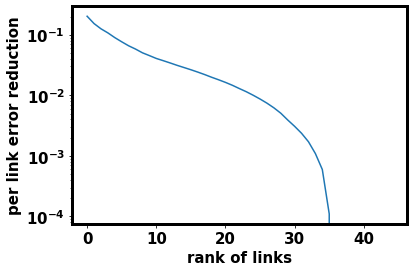

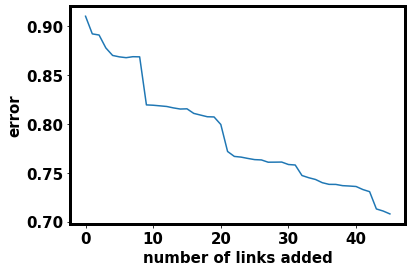

In [50]:
plt.figure()
plt.plot(np.cumsum(np.sort(df_added_tables['error reduced'].values))[::-1])
plt.yscale('log')
plt.ylabel('per link error reduction')
plt.xlabel('rank of links')

plt.figure()
plt.plot(error_list)
plt.ylabel('error')
plt.xlabel('number of links added')

## Generate p-value by comparing the added links to links in the MAMBO

3230 30787
0.1049144119271121
Of 30 valid links existing in MAMBO, there are 16 found by the GutCP.
The p-value of this is 7.831660628898618e-06


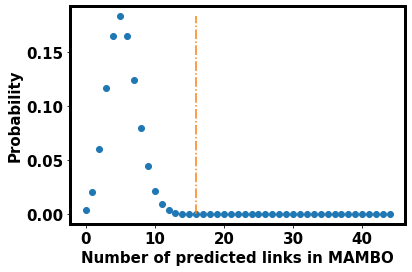

In [49]:
chia_microbes_in_Thai = df_microbes.reset_index().set_index('newID').loc[metagenome_ID].values.flatten()
chia_metabolites_in_Thai = df_metabolites.reset_index().set_index('newID').loc[df_metabolites['newID']].values.flatten()

df_MAMBO = pd.read_csv("mambo_curated.txt", sep = '\t')
df_MAMBO_filtered = df_MAMBO[df_MAMBO['microbe_ID'].apply(lambda x: x in chia_microbes_in_Thai)]
df_MAMBO_filtered = df_MAMBO_filtered[df_MAMBO_filtered['metabolite_ID'].apply(lambda x: x in chia_metabolites_in_Thai)]

df_MAMBO_filtered_newID = df_MAMBO_filtered[['microbe_ID', 'metabolite_ID']].copy()
df_MAMBO_filtered_newID.columns = ['microbes', 'metabolites']
df_MAMBO_filtered_newID['microbes'] = df_microbes.loc[df_MAMBO_filtered_newID['microbes']].values
df_MAMBO_filtered_newID['metabolites'] = df_metabolites.loc[df_MAMBO_filtered_newID['metabolites']].values
s1 = df_MAMBO_filtered_newID
s2 = net[['metabolites', 'microbes']]
numOverlap = len(pd.merge(s1, s2, how='inner'))

print((len(df_MAMBO_filtered)-numOverlap), (x.shape[0] - len(net_ori)))
print((len(df_MAMBO_filtered)-numOverlap) / (x.shape[0] - len(net_ori)) )

k = 0
l = 0
ifIncluded = np.zeros((NUMADDED))
ifCovered = np.zeros((NUMADDED))
for i in range(NUMADDED):
    if (np.sum((df_MAMBO['microbe_ID'] == df_added_tables['microbes ID'].iloc[i])) >=1 and 
       np.sum((df_MAMBO['metabolite_ID'] == df_added_tables['metabolite ID'].iloc[i]))>=1):
        ifCovered[i] = 1
        l += 1
    if np.sum((df_MAMBO['microbe_ID'] == df_added_tables['microbes ID'].iloc[i]) & 
       (df_MAMBO['metabolite_ID'] == df_added_tables['metabolite ID'].iloc[i]))>=1:
        ifIncluded[i] = 1
        k += 1
print('Of '+str(l)+' valid links existing in MAMBO, there are '+str(k)+' found by the GutCP.')

from scipy.stats import bernoulli, binom
xx = range(NUMADDED)
p = len(df_MAMBO_filtered) / x.shape[0]
#prob = bernoulli.cdf(xx, p)
probCum = binom.cdf(xx, NUMADDED, p)
prob = binom.pmf(xx, NUMADDED, p)
plt.plot(xx, prob, 'o')
plt.plot([k, k], [0, np.max(prob)], '-.')
plt.xlabel('Number of predicted links in MAMBO')
plt.ylabel('Probability')
p_value = 1 - probCum[k]
print('The p-value of this is',str(p_value))
